In [2]:
from dataclasses import dataclass
from typing import List, Optional
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
import numpy as np

import torch
import faster_whisper
import whisper

import IPython.display as ipd

In [3]:
def readAudioFile(audio_path):
    audio, sample_rate = sf.read(audio_path)
    if audio.ndim > 1:
        audio = audio[:, 0]
    if sample_rate != 16000:
        audio = librosa.resample(audio, orig_sr=sample_rate, target_sr=16000)
    return audio.astype("float32")

In [4]:
audio=readAudioFile("/mnt/e/Download/ja_test_0/common_voice_ja_19485250.mp3")
ipd.Audio(audio, rate=16000)

In [5]:
def displayLogMelSpectrogram(mel):
    # display log mel spectrogram IPython.display
    plt.figure(figsize=(10, 4))
    plt.imshow(mel, origin='lower', aspect='auto', cmap='jet')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.tight_layout()
    plt.show()

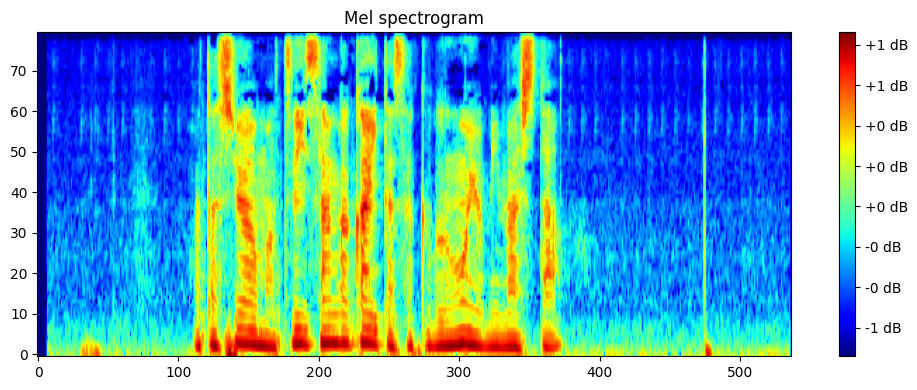

In [6]:
# get log_mel_spectrogram using faster whisper
# https://github.com/guillaumekln/faster-whisper/blob/5a0541ea7d054aa3716ac492491de30158c20057/faster_whisper/feature_extractor.py#L48
"""
Compute the log-Mel spectrogram of the provided audio, gives similar results
whisper's original torch implementation with 1e-5 tolerance.
"""
ft=faster_whisper.feature_extractor.FeatureExtractor()

window = np.hanning(ft.n_fft + 1)[:-1]

frames = ft.fram_wave(audio)
stft = ft.stft(frames, window=window)
magnitudes = np.abs(stft[:, :-1]) ** 2

filters = ft.mel_filters
mel_spec = filters @ magnitudes

log_spec = np.log10(np.clip(mel_spec, a_min=1e-10, a_max=None))
log_spec = np.maximum(log_spec, log_spec.max() - 8.0)
mel = (log_spec + 4.0) / 4.0

displayLogMelSpectrogram(mel)


In [7]:
import sys
import os
from pathlib import Path

base_dir=f'{Path(os.getcwd()).parent}'
sys.path.append(base_dir)

from faster_whisper import WhisperModel

model=WhisperModel(
    "base",
    device="cuda",
    compute_type="float32",
    download_root=f"{base_dir}/.model_cache",
)


In [41]:
from faster_whisper.tokenizer import Tokenizer
tokenizer = Tokenizer(
    model.hf_tokenizer,
    model.model.is_multilingual,
    task="transcribe",
    language="ja",
)
prompt = tokenizer.sot_sequence
prompt.append(tokenizer.no_timestamps)
prompt.extend(tokenizer.encode("[laughing]"))
prompt

[50258, 50266, 50359, 50363, 58, 4986, 60, 50257]

In [46]:
#使用可能なメソッドの一覧
from ctranslate2._ext import WhisperDecoder


ImportError: cannot import name 'WhisperDecoder' from 'ctranslate2._ext' (/home/sylx/project/altbot/ai-service/venv/lib/python3.10/site-packages/ctranslate2/_ext.cpython-310-x86_64-linux-gnu.so)

In [42]:
from faster_whisper.transcribe import TranscriptionOptions, get_suppressed_tokens

encoder_output = None

#audio=readAudioFile("/mnt/e/Download/ja_test_0/common_voice_ja_19485250.mp3")
audio=readAudioFile("/mnt/e/Download/laughterscape_ver1.0/ver1.0/denoised/spkr001-utt005.wav")
features = model.feature_extractor(audio)

options = TranscriptionOptions(
    beam_size=1,
    best_of=5,
    patience=1,
    length_penalty=1,
    repetition_penalty=1,
    no_repeat_ngram_size=0,
    log_prob_threshold=-1.0,
    no_speech_threshold=0.6,
    compression_ratio_threshold=2.4,
    condition_on_previous_text=True,
    prompt_reset_on_temperature=0.5,
    temperatures=[
        0.0
    ],
    initial_prompt="",
    prefix="",
    suppress_blank=True,
    suppress_tokens=get_suppressed_tokens(tokenizer, [-1]),
    without_timestamps=False,
    max_initial_timestamp=1.0,
    word_timestamps=False,
    prepend_punctuations="\"'“¿([{-",
    append_punctuations="\"'.。,，!！?？:：”)]}、",
)

segment = features[:, : model.feature_extractor.nb_max_frames]
encoder_output = model.encode(segment)

kwargs = {
    "beam_size": options.beam_size,
    "patience": options.patience,
}
result=model.model.generate(
                encoder_output,
                [prompt],
                beam_size=15,
                num_hypotheses=15,
                return_scores=True,
                return_no_speech_prob=True,                
            )[0]
for i in range(0,len(result.sequences_ids)):
    print(f"{i}: {tokenizer.decode(result.sequences_ids[i])} {result.scores[i]}")

0: [laughing]。 -0.5141462087631226
1: [laughing]! -0.8104643821716309
2: [laughing]w -0.8446757197380066
3: [laughing]!! -0.8874081373214722
4: [laughing] you -0.9243471026420593
5: [laughing]・・・ -0.9586039781570435
6: [laughing] me -0.9778681993484497
7: [laughing]っ -1.0256456136703491
8: [laughing]2 -1.0260651111602783
9: [laughing] えっ -1.0342990159988403
10: [laughing]あ -1.0842219591140747
11: [laughing] えー -1.1667309999465942
12: [laughing]よ -1.2037720680236816
13: [laughing] ええ -1.267939805984497
14: [laughing]よいしょ -1.2739304304122925


In [10]:
model.model

In [26]:
class_names='''[cat]
[keyboard_typing]
[sneezing]
[laughing]
[breathing]
'''
class_names = [c.strip() for c in class_names.split("\n")]
class_names.pop()

ft = FeatureExtractor()
audio_features_from_empty_input = calculate_audio_features(None, ft)

displayLogMelSpectrogram(audio_features_from_empty_input)



NameError: name 'FeatureExtractor' is not defined

In [ ]:
import sys
import os
from pathlib import Path

base_dir=f'{Path(os.getcwd()).parent}'
sys.path.append(base_dir)

model = faster_whisper.WhisperModel(
    "base",
    device="cuda",
    compute_type="float32",
    download_root=f"{base_dir}/.model_cache",
)

In [ ]:
sampling_rate = 16000
duration = audio.shape[0] / sampling_rate
features = audio_features_from_empty_input
language = "ja"

tokenizer = faster_whisper.tokenizer.Tokenizer(
        model.hf_tokenizer,
        model.model.is_multilingual,
        task="transcribe",
        language="ja",
    )
class_names='''[cat]
[keyboard_typing]
[sneezing]
[laughing]
[breathing]
'''
class_names = [c.strip() for c in class_names.split("\n")]
class_names.pop()

from faster_whisper.transcribe import TranscriptionOptions

for i,class_name in enumerate(class_names):
    class_name_tokens = tokenizer.encode(class_name)
    encoder_output = model.encode(features)
    prompt = model.get_prompt(
        tokenizer,
        class_name_tokens,
        without_timestamps=True,
        prefix=None
    )
    options = TranscriptionOptions(
        beam_size=3,
        best_of=5,
        patience=1.0,
        length_penalty=1.0,
        repetition_penalty=1.0,
        no_repeat_ngram_size=0,
        log_prob_threshold=-1.0,
        no_speech_threshold=0.6,
        compression_ratio_threshold=2.4,
        condition_on_previous_text=False,
        prompt_reset_on_temperature=0.5,
        temperatures= [
            0.0,
            0.2,
            0.4,
            0.6,
            0.8,
            1.0,
        ],
        initial_prompt="",
        prefix="",
        suppress_blank=True,
        suppress_tokens=[],
        without_timestamps=True,
        max_initial_timestamp=0.0,
        word_timestamps=False,
        prepend_punctuations = "\"'“¿([{-",
        append_punctuations = "\"'.。,，!！?？:：”)]}、",       
    )
    print(f'{i} {class_name} {class_name_tokens}')
    (
        result,
        avg_logprob,
        temperature,
        compression_ratio,
    ) = model.generate_with_fallback(encoder_output,
                                     prompt, tokenizer,options)
    print(avg_logprob)
